<a href="https://colab.research.google.com/github/dshenker/ML2020FinalProject/blob/main/ApplyingToYaleData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Application to Yale Dataset

Here we explore how our models can generalize to a new dataset. As we'll see here, we do not get very good performance, largely because dlib struggled on this data, something we did not expect would happen. However, our first CNN (which does not rely on dlib), did achieve decent accuracy, suggesting that there is hope that these models could work on new and diverse images.

In [243]:
import pandas as pd
!apt-get install build-essential cmake
!apt-get install libopenblas-dev liblapack-dev 
!pip3 install dlib
import dlib

Reading package lists... Done
Building dependency tree       
Reading state information... Done
build-essential is already the newest version (12.4ubuntu1).
cmake is already the newest version (3.10.2-1ubuntu2.18.04.1).
0 upgraded, 0 newly installed, 0 to remove and 14 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
liblapack-dev is already the newest version (3.7.1-4ubuntu1).
libopenblas-dev is already the newest version (0.2.20+ds-4).
0 upgraded, 0 newly installed, 0 to remove and 14 not upgraded.


In [244]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt

In [245]:
import cv2

In [246]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [247]:
landmark_detector = dlib.shape_predictor('drive/MyDrive/ML_Final/shape_predictor_68_face_landmarks.dat')

In [248]:
import os
import numpy as np
import tqdm
from PIL import Image

directory = r'drive/MyDrive/ML_Final/yale_data/'

for filename in tqdm.tqdm(os.listdir(directory)):
    if (filename != "Jpegs"):
      curr_image = Image.open('drive/MyDrive/ML_Final/yale_data/' + filename)
      curr_image = curr_image.resize((350, 350))
      curr_image.save('drive/MyDrive/ML_Final/yale_data/Jpegs/' + filename+'.jpg', 'JPEG')

  
  

100%|██████████| 164/164 [00:02<00:00, 81.48it/s]


In [249]:
!pip3 install scipy

In [250]:
import os
import numpy as np
import tqdm
from PIL import Image
directory = r'drive/MyDrive/ML_Final/yale_data/Jpegs'
images = []
labels = []
c = 0
import scipy
from scipy import misc
possible_emotions = ["sad", "surprised", "normal", "happy"]
for filename in os.listdir(directory):

   
  
    curr_image = dlib.load_grayscale_image('drive/MyDrive/ML_Final/yale_data/Jpegs/' + filename)
    emotion = filename.partition(".")[2]
    emotion = emotion[:-4]
    if (emotion in possible_emotions):
      images.append(curr_image)
      emotion = emotion.replace("normal", "neutral")
      emotion = emotion.replace("surprised", "surprise")
      emotion = emotion.replace("happy", "happiness")
      emotion = emotion.replace("sad", "sadness")
      labels.append(emotion)


In [251]:
from collections import Counter
Counter(labels)
labels = np.array(labels)
labels

array(['neutral', 'sadness', 'surprise', 'happiness', 'neutral',
       'surprise', 'happiness', 'neutral', 'sadness', 'surprise',
       'happiness', 'neutral', 'sadness', 'surprise', 'happiness',
       'neutral', 'surprise', 'sadness', 'happiness', 'neutral',
       'sadness', 'surprise', 'happiness', 'neutral', 'sadness',
       'surprise', 'happiness', 'neutral', 'sadness', 'surprise',
       'happiness', 'neutral', 'sadness', 'surprise', 'happiness',
       'neutral', 'sadness', 'surprise', 'happiness', 'neutral',
       'sadness', 'surprise', 'happiness', 'neutral', 'sadness',
       'surprise', 'happiness', 'neutral', 'sadness', 'surprise',
       'sadness', 'happiness', 'neutral', 'sadness', 'surprise',
       'happiness', 'neutral', 'sadness', 'surprise', 'happiness'],
      dtype='<U9')

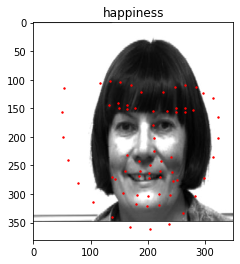

In [252]:
img = images[30]
rect = dlib.rectangle(0,0,img.shape[1],img.shape[0])
landmarks = landmark_detector(img,rect)
plt.figure()
plt.title(labels[30])
plt.imshow(img,cmap='gray', vmin=0, vmax=255)
for p in landmarks.parts():
  plt.scatter(p.x,p.y,s=2,c='r')


Unfortunately, dlib doesn't seem to be working properly here. Let's take a further look at what's going on by cropping the image a bit.

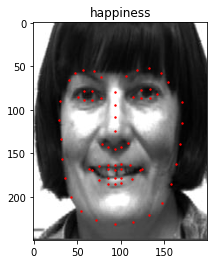

In [253]:
img = images[30][100:,100:300]

rect = dlib.rectangle(0,0,img.shape[1],img.shape[0])
landmarks = landmark_detector(img,rect)
plt.figure()
plt.title(labels[30])
plt.imshow(img,cmap='gray', vmin=0, vmax=255)
for p in landmarks.parts():
  plt.scatter(p.x,p.y,s=2,c='r')

When we input to dlib a tight crop of the same face, we can see that the issue corrects itself. This problematic because it implies that dlib will not be able to automatically generate solid facial features for the images in this set. If we had more time, this is an area we would address.

Now we are going to try repeating this automatically.

[(114, 134) (293, 313)]


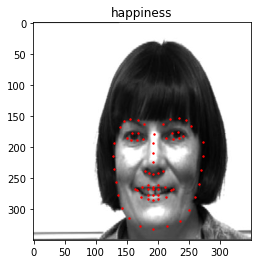

In [254]:
img = images[30]
detector = dlib.get_frontal_face_detector()
#print bounding rectangle
print(detector(img)[0])
rect = detector(img)[0]
landmarks = landmark_detector(img,rect)
plt.figure()
plt.title(labels[30])
plt.imshow(img,cmap='gray', vmin=0, vmax=255)
for p in landmarks.parts():
  plt.scatter(p.x,p.y,s=2,c='r')



Looks pretty good!

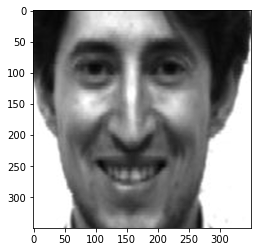

In [255]:
images = np.array(images)
landmarks = []
processed_images = []
detector = dlib.get_frontal_face_detector()


for img in images:
  bounds = detector(img)[0]
  #it will be pretty tight so I will expand it
  img = img[bounds.top()-10:bounds.bottom()+10,bounds.left()-10:bounds.right()+10].copy()

  #now going to resize again to 350 by 350
  img = cv2.resize(img, dsize=(350, 350), interpolation=cv2.INTER_CUBIC)

  processed_images.append(img)
  plt.imshow(img,cmap='gray', vmin=0, vmax=255)
  
  rect = dlib.rectangle(0,0,img.shape[1],img.shape[0])
  landmark_curr = landmark_detector(img,rect)
  landmarks.append([[i.x,i.y] for i in landmark_curr.parts()])

images = np.array(processed_images)
landmarks = np.array(landmarks)

In [256]:
landmarks_flat = np.reshape(landmarks, (60, 136))
landmarks_flat.shape

(60, 136)

## SVM

In [257]:
from sklearn.svm import SVC
from sklearn import preprocessing
y_train = np.load('drive/MyDrive/ML_Final/Upsampled_Data/y_train_upsample_final.npy')
le = preprocessing.LabelEncoder()
le.fit(y_train)
labels = le.transform(labels)

In [258]:
from joblib import dump, load
#load svm
clf = load('drive/MyDrive/ML_Final/Models/svm.joblib')

In [259]:
clf.score(landmarks_flat, labels)

0.48333333333333334

We see that there is very poor performance using our trained SVM. This is likely due to the dlib errors we saw earlier. 

In [260]:
y_test_pred = clf.predict(landmarks_flat)
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix, classification_report
conf_norm = normalize(confusion_matrix(labels,y_test_pred), norm="l1")
conf_norm = np.round(conf_norm, 2)
print(conf_norm)

[[0.   0.   0.   0.   0.  ]
 [0.13 0.53 0.27 0.   0.07]
 [0.4  0.   0.4  0.   0.2 ]
 [0.2  0.   0.53 0.   0.27]
 [0.   0.   0.   0.   1.  ]]


## Resnet CNN

In [261]:
import torch
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader, random_split
#load in the cnn
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cnn = torch.load('drive/MyDrive/ML_Final/Models/Final_Models/cnn_fin.pt')

In [262]:
#define dataset class
class Dataset(Dataset):
    
    def __init__(self, features, labels):

        self.features = features
        plt.imshow(features[50],cmap='gray', vmin=0, vmax=255)
        self.features = self.features.astype(np.float32) / 255.0
        #going to try and normalize
        sum_m,sum_std = 0,0
        for img in self.features:
          sum_m += img.mean()
          sum_std += img.std()
        m = sum_m / self.features.shape[0]
        s = sum_std / self.features.shape[0]

        imgs_arr = []
        for img in self.features:

           imgs_arr.append([img,img,img])

        self.features = np.array(imgs_arr)
        print(self.features.shape)
        self.features = (self.features - m) / s
  
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, index):
        feature = np.expand_dims(self.features[index,:,:],0)
        label = self.labels[index]
        return feature, label

(60, 3, 350, 350)


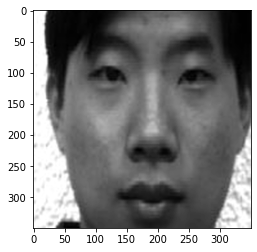

In [263]:
data = Dataset(images, labels)

In [264]:
loader = DataLoader(data, batch_size=1, shuffle=True,drop_last=False)

In [265]:
cnn.eval()
pred_yale = []
lab_yale = []
for data in loader:
  feature, label = data
  feature = feature.view(1,3,350,350)

  lab_yale.append(label)
  pred_yale.append(torch.argmax(cnn(feature.type(torch.FloatTensor if not torch.cuda.is_available() else torch.cuda.FloatTensor))))


In [266]:
pred_yale = np.array(pred_yale)
lab_yale = np.array(lab_yale)
print("train set accuracy: " + str(np.sum(pred_yale == lab_yale) / len(lab_yale)))

train set accuracy: 0.6833333333333333


First, the accuracy here is much better than we saw with the SVM. However, it is still not near to where we were with our original github test and dev sets. This suggests that the cnn model we built is not very generalizable to a new type of image. This could be due to the same cropping issue we saw above.

## MTCNN

In [267]:
import torch
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler, normalize
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix, classification_report
from skimage import transform
from torchvision import models

In [268]:
import torch
import torch.nn as nn
import torch.optim as optim

class MultiTaskLoss(nn.Module):
    def __init__(self, model):
        super(MultiTaskLoss, self).__init__()
        self.model = model
        self.cross_entropy = nn.CrossEntropyLoss()
        self.mse = nn.MSELoss()
        #empirically determined ratio based on preruns
        self.wt = nn.Parameter(torch.tensor([37.5]))


    def forward(self, input, labels, points):
        outputs = self.model(input)
        loss = 0
        for i in range(len(outputs[0])):
          loss += self.wt * (self.cross_entropy(outputs[0][i].view(1,5),labels[i].view(1).long()))
          loss += (self.mse(outputs[1][i].view(1,136),points[i].view(1,-1))) / self.wt
        return loss / len(outputs[0])



class MultiTaskModel(nn.Module):
    def __init__(self):
        super(MultiTaskModel, self).__init__()
        #initial extractor prior to global average pooling
        self.extractor = list(models.resnet18(pretrained=True).children())[:-2]
        self.extractor = nn.Sequential(*self.extractor)

        self.gap = torch.nn.AdaptiveAvgPool2d((1,1))
        self.fc = torch.nn.Linear(512,5)

        self.p_fc = torch.nn.Linear(512*11*11,136)
        


    def forward(self, input):
        x = self.extractor(input)
        y = self.p_fc(x.view(-1,512*11*11))
        x = self.gap(x)
        x = self.fc(x.view(-1,512))
        label,points = x.view(-1,5), y.view(-1,136)
        return label,points

#sending to CUDA
mtl = MultiTaskLoss(model=MultiTaskModel())
mtl.to(device)
mtl.model.to(device)

MultiTaskModel(
  (extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_st

In [269]:
mtcnn = torch.load('drive/MyDrive/ML_Final/Models/Final_Models/mt-cnn_fin_2.pt')

In [270]:
class Dataset(Dataset):
    
    def __init__(self, images, labels, detector_path):
        #data = np.load(file_path,allow_pickle=True)
        landmark_detector = dlib.shape_predictor(detector_path)
        #self.features = data["x"]
        self.features = images
        plt.imshow(self.features[50],cmap='gray', vmin=0, vmax=255)
        print(self.features.shape)

        ## Regenerating Facial Landmarks
        self.landmarks = []
        for img in self.features:
          rect = dlib.rectangle(0,0,img.shape[1],img.shape[0])
          landmark_curr = landmark_detector(img,rect)
          temp = [i.x for i in landmark_curr.parts()]
          for i in landmark_curr.parts():
            temp.append(i.y)
          self.landmarks.append(temp)
        self.landmarks = np.array(self.landmarks)



        ## Scaling and normalizing features
        self.features = self.features.astype(np.float32) / 255.0
        sum_m,sum_std = 0,0
        for img in self.features:
          sum_m += img.mean()
          sum_std += img.std()
        m = sum_m / self.features.shape[0]
        s = sum_std / self.features.shape[0]

        ### Duplicating to 3 channels -- choosing not to resize
        imgs_arr = []
        for img in self.features:
        #  new_im = transform.resize(img,(224,224))
        ## each needs three "channels"
           imgs_arr.append([img,img,img])
        self.features = np.array(imgs_arr)
        
        #showing updated shape
        print(self.features.shape)
        self.features = (self.features - m) / s
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, index):
        feature = np.expand_dims(self.features[index,:,:],0)
        label = self.labels[index]
        pts = self.landmarks[index]
        return feature, label, pts

(60, 350, 350)
(60, 3, 350, 350)


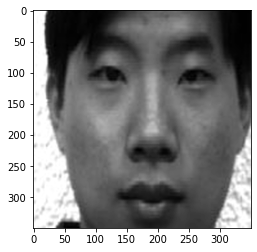

In [271]:
data = Dataset(images, labels,'drive/MyDrive/ML_Final/shape_predictor_68_face_landmarks.dat')

We notice that this image was automatically cropped much more tightly than in the github dataset.

In [272]:
loader = DataLoader(data, batch_size=1, shuffle=True,drop_last=False)

In [273]:
mtl.eval()
mtl.model.eval()
pred_train = []
lab_train = []

for data in loader:
    feature, label, points = data
    feature = feature.view(1,3,350,350)
    feature, label,points = feature.to(device),label.to(device),points.to(device)

    ft = feature.type(torch.FloatTensor if not torch.cuda.is_available() else torch.cuda.FloatTensor)
    lb = label.type(torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor)
    pt = points.type(torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor)



    lab_train.append(label)
    pred_train.append(torch.argmax(mtl.model(feature.type(torch.FloatTensor if not torch.cuda.is_available() else 
                                                      torch.cuda.FloatTensor))[0]))

In [274]:
pred_train = np.array(pred_train)
lab_train = np.array(lab_train)
print("train set accuracy: " + str(np.sum(pred_train == lab_train) / len(lab_train)))

train set accuracy: 0.23333333333333334


Similar to SVM, the MTCNN appears to struggle here. This is likely because, once again, we are relying on dlib to get landmarks, which are included as part of the loss function. Since dlib is not functioning properly here, it is as if we are giving the model poor data to use. As a result, it is not very surprising that the MTCNN struggles.